In [2]:
import json
import pandas as pd
import time
import datetime
import gcsfs
import numpy as np
import gender_guesser.detector as gender
from datetime import date
from google.cloud import storage
from google.cloud import bigquery

from pathlib import Path
import os

PROJ_ROOT = Path().resolve().parent
KEYS_DIR = PROJ_ROOT / 'keys' 
keys = KEYS_DIR / 'Keys for Big Query Storage Admin - PEII.json'

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = str(keys)

In [3]:
# Get today's date
today = datetime.datetime.today().date()

# Instantiate bigquery client
client = bigquery.Client()
job_config = bigquery.QueryJobConfig()


In [4]:
# Get processed entrepreneur table from BQ
entrepreneur_query = """
    #standardSQL
    SELECT *
    FROM `peii-242723.entrepreneur_data.processed_entrepreneur_data`
    """

In [5]:
entrepreneur_query_job = client.query(entrepreneur_query, location = 'US')
entrepreneur_result = entrepreneur_query_job.result()

# Creates dataframe of entrepreneur names
entrepreneur_df = entrepreneur_result.to_dataframe()

In [19]:
entrepreneur_df

,name,company_name,crunchbase_uuid,crunchbase_permalink,funding,jobs_created,patents,ipo,city,state,state_abbrev,cbsa_code,csa_code,gender,lgbtq,race_ethnicity,startout_id,first_name
0,Darron Schall,Benefit Mobile,aeedf831d6ad9f6d63a4393915c4117e,benefit-mobile-inc,2700378,50.0,0.0,0,Ada,Michigan,MI,"Ada, Michigan","Ada, Michigan",Male,None,None,None,darron
1,Shane O'Donnell,Benefit Mobile,aeedf831d6ad9f6d63a4393915c4117e,benefit-mobile-inc,2700378,50.0,0.0,0,Ada,Michigan,MI,"Ada, Michigan","Ada, Michigan",Male,None,None,None,shane
2,Derik Lolli,Benefit Mobile,aeedf831d6ad9f6d63a4393915c4117e,benefit-mobile-inc,2700378,50.0,0.0,0,Ada,Michigan,MI,"Ada, Michigan","Ada, Michigan",Male,None,None,None,derik
3,Jim Bologna,BFile System,7459aecfd94c4419af7e3f4092dc124e,bfile-system,0,50.0,0.0,0,Ray,Michigan,MI,19820.0,220.0,None,None,None,None,jim
4,Blake George,BFile System,7459aecfd94c4419af7e3f4092dc124e,bfile-system,0,50.0,0.0,0,Ray,Michigan,MI,19820.0,220.0,None,None,None,None,blake
5,David Marra,Arialytics,23bd37368acb0d45f7ce6aea87c79306,arialytics,0,10.0,1.0,0,Rye,New York,NY,35620.0,408.0,None,None,None,None,david
6,Tarek Fadel,Fadel Partners,4445963b62b102bce905535621a393f1,fadel-partners,7000000,100.0,9.0,0,Rye,New York,NY,35620.0,408.0,None,None,None,None,tarek
7,John Arenas,Serendipity Labs Coworking,56ef66f279d0df8f9906bd7a95f40e13,serendipity-labs,100297908,100.0,0.0,0,Rye,New York,NY,35620.0,408.0,Male,None,None,None,john
8,Nick Koshnick,Solum,6cfc942cc4c2e6b30691eefcc788dccb,solum-2,23500000,50.0,1.0,0,Ames,Iowa,IA,11180.0,218.0,Male,None,None,None,nick
9,Mike Preiner,Solum,6cfc942cc4c2e6b30691eefcc788dccb,solum-2,23500000,50.0,1.0,0,Ames,Iowa,IA,11180.0,218.0,Male,None,None,None,mike


In [18]:
# Create first name column
for i in entrepreneur_df.index:
    entrepreneur_df.at[i, 'first_name'] = entrepreneur_df.at[i, 'name'].split(' ')[0].lower()

# Query only null values
null = entrepreneur_df[pd.isnull(entrepreneur_df['gender'])]

In [10]:
entrepreneur_df.shape

(38497, 18)

In [9]:
null_df.shape

(20042, 18)

In [11]:
number_null = entrepreneur_df.shape[0] - null_df.shape[0]
number_null

18455

In [14]:
# Get only unique names that are female, and aggregate the record number for each name
female_names_query = """
    #standardSQL
    SELECT name, SUM(number) as records
    FROM `bigquery-public-data.usa_names.usa_1910_current`
    WHERE gender = 'F'
    GROUP BY name
    ORDER BY records DESC
    """

female_names_query_job = client.query(female_names_query, location = 'US')
female_names_result = female_names_query_job.result()

# Create dataframe of male names
female_names_df = female_names_result.to_dataframe()

In [16]:
# Takes only the names and turns it into a list
female_names = female_names_df['name'].to_list()
    
# Lowercase
for i in range(len(female_names)):
    female_names[i] = female_names[i].lower()

# Creates a separate list for male names because it is faster to use SQL than iterate through df
male_names_query = """
    #standardSQL
    SELECT name, SUM(number) as records
    FROM `bigquery-public-data.usa_names.usa_1910_current`
    WHERE gender = 'M'
    GROUP BY name
    ORDER BY records DESC
    """

male_names_query_job = client.query(male_names_query,location = 'US')
male_names_result = male_names_query_job.result()

# Create dataframe of male names
male_names_df = male_names_result.to_dataframe()
# Take only the male names and turns it into a list
male_names = male_names_df['name'].to_list()
# Lowercase
for i in range(len(male_names)):
    male_names[i] =  male_names[i].lower()

# Find androgynous names
andro_names = (set(male_names).intersection(female_names))

# Female names not in male list
female_names = set(female_names) - set(male_names)

# Male names not in female list
male_names = set(male_names) - set(female_names)

# Make everything into lists
andro_names = list(andro_names)
female_names = list(female_names)
male_names = list(male_names)

male_names_df = male_names_df.set_index('name')
female_names_df = female_names_df.set_index('name')


In [25]:
count_male = 0
count_female = 0
count_na = 0
femme = []
masc = []

# Sort androgynous names
for name in andro_names:
    name = name.capitalize()
    male_count = male_names_df.loc[name]['records']
    female_count = female_names_df.loc[name]['records']
    total = male_count + female_count
    percentage_male = round(male_count / total, 2)
    percentage_female = round(female_count / total, 2)
    if percentage_male >= 0.667:
        gender_assign = 'M'
        count_male += 1
        masc.append(name.lower())
    elif percentage_female >= 0.667:
        gender_assign = 'F'
        count_female += 1
        femme.append(name.lower())
    else:
        gender_assign = 'N/A'
        count_na += 1

    # x = 10 - len(str(male_count + female_count))
    # y = 10 - len(name)
    #debugging
    #print(name, y*' ', male_count, female_count, x*' ', ' | ', percentage_male, percentage_female, ' | ', gender_assign)

# Combine lists
female_names = female_names + femme
male_names = male_names + masc

# Unidentified names
andro_ = set(andro_names) - set(masc)
andro_ = set(andro_) - set(femme)

In [26]:
# Assign gender from social security data
female_count = 0
male_count = 0
andro_count = 0
na_count = 0

for i in null.index:
    name = null.at[i, 'first_name'].lower()

    if name in female_names:
        entrepreneur_df.at[i, 'gender'] = 'f'
        female_count += 1

    elif name in male_names:
        entrepreneur_df.at[i, 'gender'] = 'm'
        male_count += 1

    elif name in andro_:
        entrepreneur_df.at[i, 'gender'] = 'andro'
        andro_count += 1

    else:
        entrepreneur_df.at[i, 'gender'] = 'unknown'
        na_count += 1

# Use the gender guesser
d = gender.Detector()

# Create additional checks for gender
additional_female_names = [
    'Alika',
    'Ama',
    'Cibelle',
    'Kimberlina',
    'Leathia',
    'Shiri',
    'Lavena',
    'Tanjila',
    'Holley',
    'Anie',
    'Dionna',
    'Shanel',
    'Lakshya',
    'Shenda',
    'Madelena',
    'Kerranna',
    'Piya',
    'Paria',
    'Ylianna',
    'Ankita',
    'Isha',
    'Gabby',
    'Anjelika',
    'Nitha',
    'Adena',
    'Sumayah',
    'Louisea',
    'Cymphonique',
    'Charlyn',
    'Tari',
    'Graceann',
    'Kalia',
    'Annmarie',
    'Saira',
]
additional_male_names = [
    'Deward',
    'Omkar',
    'Rohit',
    'Mohit',
    'Vik',
    'Vishal',
    'Obed',
    'Ashwin',
    'Ozel',
    'Umed',
    'Demetri',
    'Tripp',
    'Jean-Marc',
    'Laszlo',
    'Allon',
    'Rishi'
    'Francois',
    'Clarkson',
    'Siddharth',
    'Sidharth',
    'Anup',
    'Anoop',
    'Zac',
    'Andras',
    'Abhishek',
    'Dil-Domine',
    'Varun',
    'Abhinav',
    'Chaitanya',
    'Rishi',
    'Raghu',
    'Anurag',
    'Akshay',
    'Gaurav',
    'Kunal',
]

# Create column 'female'
entrepreneur_df['female'] = 0

# Collect indices of female and androgynous names, and mark them as female
female_names = []
andy_names = []
unk_names = []

count_female = 0
count_andy = 0
count_unk = 0

for i in entrepreneur_df.index:
    name = entrepreneur_df.at[i, 'first_name']
    if d.get_gender(name) == 'female':
        female_names.append([i, name])
        entrepreneur_df.at[i, 'female'] = 1
        count_female += 1
    elif d.get_gender(name) == 'mostly_female':
        female_names.append([i, name])
        entrepreneur_df.at[i, 'female'] = 1
        count_female += 1
    elif d.get_gender(name) == 'andy':
        andy_names.append([i, name])
        count_andy += 1
    elif d.get_gender(name) == 'unknown':
        if name in additional_female_names:
            female_names.append([i, name])
            entrepreneur_df.at[i, 'female'] = 1
            count_female += 1
        elif name in additional_male_names:
            pass
        else:
            unk_names.append([i, name])
            count_unk += 1
            

for i in entrepreneur_df.index:
    # Over-ride the gender_guesser with the social security data
    if entrepreneur_df.at[i, 'gender'] == 'f' and entrepreneur_df.at[i, 'female'] == 0:
        entrepreneur_df.at[i, 'gender'] = 'Female'
    if entrepreneur_df.at[i, 'gender'] == 'm' and entrepreneur_df.at[i, 'female'] == 1:
        entrepreneur_df.at[i, 'gender'] = 'Male'

    # Assign female if both agree, and male if both agree
    if entrepreneur_df.at[i, 'gender'] == 'f' and entrepreneur_df.at[i, 'female'] == 1:
        entrepreneur_df.at[i, 'gender'] = 'Female'
    if entrepreneur_df.at[i, 'gender'] == 'm' and entrepreneur_df.at[i, 'female'] == 0:
        entrepreneur_df.at[i, 'gender'] = 'Male'



In [33]:
entrepreneur_df['ent'] = 1

In [36]:
for i in entrepreneur_df.index:
    if entrepreneur_df.at[i, 'gender'] == 'Female':
        entrepreneur_df.at[i, 'female'] = 1

In [27]:
entrepreneur_df.gender.value_counts()

Male       31693
Female      3921
unknown     2883
Name: gender, dtype: int64

In [28]:
3921/31693

0.12371817120499795

In [38]:
ent_csa_df = entrepreneur_df.groupby('csa_code').sum()
ent_csa_df

,funding,jobs_created,patents,ipo,female,ent
csa_code,,,,,,
104.0,51029940,670.0,48.0,0,3,21
106.0,2063020619,8490.0,81.0,0,4,68
107.0,45724469,50.0,7.0,0,1,1
108.0,0,50.0,3.0,0,0,1
120.0,711890470,1300.0,5.0,0,1,21
122.0,16048377023,100050.0,1708.0,17,61,647
140.0,182857805,1030.0,0.0,0,5,18
142.0,335711082,3010.0,33.0,0,4,47
144.0,31804465,2340.0,4.0,0,1,12


In [39]:
ent_csa_df['percent_womyn'] = ent_csa_df['female'] / ent_csa_df['ent']
    

In [115]:
entrepreneur_df[entrepreneur_df.name == 'Christine Martin']

,name,company_name,crunchbase_uuid,crunchbase_permalink,funding,jobs_created,patents,ipo,city,state,state_abbrev,cbsa_code,csa_code,gender,lgbtq,race_ethnicity,startout_id,first_name,female,ent
1039,Christine Martin,Boulder Ionics,1ed1a2fd951bfc57a7c733ae1d5f6ada,boulder-ionics,4800000,50.0,2.0,0,Arvada,Colorado,CO,"Arvada, Colorado","Arvada, Colorado",Female,None,None,None,christine,1,1


In [58]:
# round to the nearest int (?)
# np.round, nearest whole don't include number
.14 * 21

2.9400000000000004

In [85]:
ent_csa_df = ent_csa_df.reset_index()

In [89]:
ent_csa_df[ent_csa_df.csa_code == 'Ada, Michigan']

,csa_code,funding,jobs_created,patents,ipo,female,ent,percent_womyn
125,"Ada, Michigan",8101134,150.0,0.0,0,0,3,0.0


In [91]:
ent_csa_df.iloc[124, :]

csa_code         566.0
funding          50000
jobs_created        20
patents              2
ipo                  0
female               0
ent                  2
percent_womyn        0
Name: 124, dtype: object

In [92]:
ent_csa_df.iloc[126, :]

csa_code         Addison, Texas
funding                74779000
jobs_created               1130
patents                       3
ipo                           0
female                        0
ent                          15
percent_womyn                 0
Name: 126, dtype: object

In [94]:
list(ent_csa_df['csa_code'])

['104.0',
 '106.0',
 '107.0',
 '108.0',
 '120.0',
 '122.0',
 '140.0',
 '142.0',
 '144.0',
 '146.0',
 '147.0',
 '148.0',
 '150.0',
 '160.0',
 '162.0',
 '163.0',
 '168.0',
 '170.0',
 '172.0',
 '174.0',
 '176.0',
 '178.0',
 '184.0',
 '190.0',
 '192.0',
 '194.0',
 '198.0',
 '206.0',
 '209.0',
 '212.0',
 '216.0',
 '218.0',
 '220.0',
 '233.0',
 '238.0',
 '240.0',
 '244.0',
 '258.0',
 '260.0',
 '264.0',
 '266.0',
 '267.0',
 '268.0',
 '272.0',
 '273.0',
 '276.0',
 '277.0',
 '278.0',
 '288.0',
 '290.0',
 '292.0',
 '294.0',
 '296.0',
 '298.0',
 '300.0',
 '304.0',
 '310.0',
 '312.0',
 '313.0',
 '315.0',
 '318.0',
 '320.0',
 '324.0',
 '332.0',
 '336.0',
 '339.0',
 '340.0',
 '348.0',
 '350.0',
 '352.0',
 '356.0',
 '357.0',
 '366.0',
 '368.0',
 '370.0',
 '372.0',
 '376.0',
 '378.0',
 '388.0',
 '390.0',
 '396.0',
 '400.0',
 '406.0',
 '408.0',
 '412.0',
 '416.0',
 '420.0',
 '422.0',
 '425.0',
 '426.0',
 '428.0',
 '429.0',
 '430.0',
 '438.0',
 '440.0',
 '444.0',
 '446.0',
 '448.0',
 '450.0',
 '452.0',


In [96]:
ent_df = ent_csa_df[0:125]

In [98]:
ent_df.csa_code = ent_df.csa_code.astype(float)

/Users/dhyanna/socos/impact-index/env/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [100]:
ent_df.set_index('csa_code')

,funding,jobs_created,patents,ipo,female,ent,percent_womyn
csa_code,,,,,,,
104.0,51029940,670.0,48.0,0,3,21,0.142857
106.0,2063020619,8490.0,81.0,0,4,68,0.058824
107.0,45724469,50.0,7.0,0,1,1,1.000000
108.0,0,50.0,3.0,0,0,1,0.000000
120.0,711890470,1300.0,5.0,0,1,21,0.047619
122.0,16048377023,100050.0,1708.0,17,61,647,0.094281
140.0,182857805,1030.0,0.0,0,5,18,0.277778
142.0,335711082,3010.0,33.0,0,4,47,0.085106
144.0,31804465,2340.0,4.0,0,1,12,0.083333


In [80]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1348457f0>]],
      dtype=object)

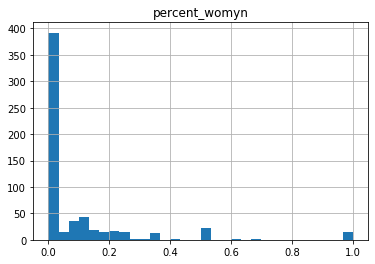

In [83]:
ent_csa_df.hist('percent_womyn', bins = 30)

In [40]:
ent_csa_df

,funding,jobs_created,patents,ipo,female,ent,percent_womyn
csa_code,,,,,,,
104.0,51029940,670.0,48.0,0,3,21,0.142857
106.0,2063020619,8490.0,81.0,0,4,68,0.058824
107.0,45724469,50.0,7.0,0,1,1,1.000000
108.0,0,50.0,3.0,0,0,1,0.000000
120.0,711890470,1300.0,5.0,0,1,21,0.047619
122.0,16048377023,100050.0,1708.0,17,61,647,0.094281
140.0,182857805,1030.0,0.0,0,5,18,0.277778
142.0,335711082,3010.0,33.0,0,4,47,0.085106
144.0,31804465,2340.0,4.0,0,1,12,0.083333


In [106]:
top_100 = ent_df[ent_df.ent >= 100]

In [486]:
top_100.sort_values(by=['percent_womyn'], ascending=False)

,csa_code,funding,jobs_created,patents,ipo,female,ent,percent_womyn
57,312.0,2943615139,14680.0,244.0,2,22,143,0.153846
87,422.0,3224429983,15150.0,164.0,1,15,118,0.127119
74,370.0,7888940961,1047310.0,461.0,11,58,469,0.123667
83,408.0,319766134560,1662770.0,3722.0,66,562,4573,0.122895
90,428.0,6826553042,22040.0,243.0,10,41,340,0.120588
67,348.0,89268394707,297940.0,4104.0,66,306,2598,0.117783
63,332.0,8130409862,6010150.0,175.0,15,13,117,0.111111
20,176.0,25352080232,99490.0,811.0,12,93,861,0.108014
112,500.0,37923329286,3204550.0,1911.0,30,133,1241,0.107172
18,172.0,2570190074,11340.0,275.0,4,12,118,0.101695


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12d40c5c0>]],
      dtype=object)

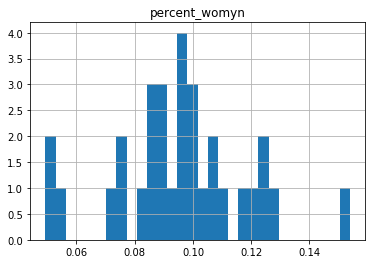

In [111]:
top_100.hist('percent_womyn', bins = 30)

In [417]:
derp = list(ser)

In [389]:
ser = top_100['percent_womyn']

In [405]:
top_100['percent_womyn']

5      0.094281
11     0.097946
18     0.101695
20     0.108014
21     0.049587
22     0.085106
26     0.054688
27     0.076023
30     0.089333
32     0.096886
48     0.088028
51     0.073529
57     0.153846
63     0.111111
67     0.117783
71     0.097701
74     0.123667
77     0.085443
81     0.081081
83     0.122895
87     0.127119
90     0.120588
91     0.075758
92     0.098446
94     0.085714
98     0.101523
105    0.096491
109    0.049351
111    0.099446
112    0.107172
121    0.088977
Name: percent_womyn, dtype: float64

TypeError: cannot unpack non-iterable AxesSubplot object

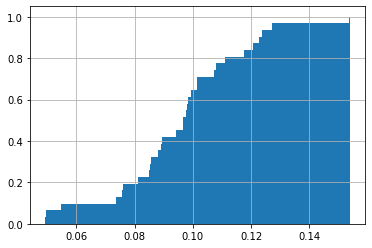

In [439]:
counts, bins, bars = ser.hist(cumulative=True, density=True, bins=1000)

In [434]:
.25*len(sorted(derp))

7.75

In [436]:
derp[8]

0.08933333333333333

In [437]:
derp[7]

0.07602339181286549

In [435]:
np.percentile(derp, 25)

0.08527471047670347

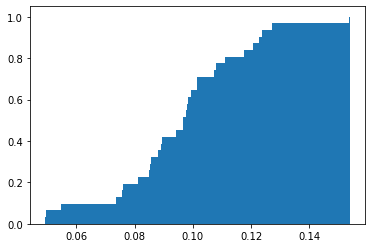

In [440]:
counts, bins, bars = plt.hist(derp,cumulative=True, density=True, bins=1000)

In [444]:
len(bins)

1001

In [443]:
counts

array([0.03225806, 0.03225806, 0.06451613, 0.06451613, 0.06451613,
       0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613,
       0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613,
       0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613,
       0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613,
       0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613,
       0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613,
       0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613,
       0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613,
       0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613,
       0.06451613, 0.09677419, 0.09677419, 0.09677419, 0.09677419,
       0.09677419, 0.09677419, 0.09677419, 0.09677419, 0.09677419,
       0.09677419, 0.09677419, 0.09677419, 0.09677419, 0.09677419,
       0.09677419, 0.09677419, 0.09677419, 0.09677419, 0.09677419,
       0.09677419, 0.09677419, 0.09677419, 0.09677419, 0.09677

In [446]:
dic_n = {}
for i in range(len(counts)):
    dic_n[counts[i]] = bins[i]

In [448]:
dic_n

{0.03225806451612904: 0.04945514485514486,
 0.06451612903225808: 0.05457542457542458,
 0.09677419354838712: 0.07338461538461538,
 0.12903225806451615: 0.07557902097902099,
 0.16129032258064518: 0.0758925074925075,
 0.19354838709677422: 0.08090829170829171,
 0.22580645161290325: 0.08498361638361639,
 0.25806451612903225: 0.0852971028971029,
 0.29032258064516125: 0.08550609390609391,
 0.32258064516129026: 0.08790949050949051,
 0.35483870967741926: 0.08884995004995005,
 0.38709677419354827: 0.08916343656343656,
 0.41935483870967727: 0.09407472527472528,
 0.4516129032258063: 0.09637362637362637,
 0.4838709677419353: 0.0966871128871129,
 0.5161290322580643: 0.09752307692307693,
 0.5483870967741933: 0.09783656343656344,
 0.5806451612903223: 0.09825454545454546,
 0.6129032258064513: 0.09929950049950051,
 0.6451612903225803: 0.10138941058941059,
 0.6774193548387093: 0.1014939060939061,
 0.7096774193548383: 0.10703216783216785,
 0.7419354838709673: 0.10786813186813188,
 0.7741935483870963: 0.11

In [449]:
list(dic_n.keys())

[0.03225806451612904,
 0.06451612903225808,
 0.09677419354838712,
 0.12903225806451615,
 0.16129032258064518,
 0.19354838709677422,
 0.22580645161290325,
 0.25806451612903225,
 0.29032258064516125,
 0.32258064516129026,
 0.35483870967741926,
 0.38709677419354827,
 0.41935483870967727,
 0.4516129032258063,
 0.4838709677419353,
 0.5161290322580643,
 0.5483870967741933,
 0.5806451612903223,
 0.6129032258064513,
 0.6451612903225803,
 0.6774193548387093,
 0.7096774193548383,
 0.7419354838709673,
 0.7741935483870963,
 0.8064516129032253,
 0.8387096774193543,
 0.8709677419354833,
 0.9032258064516123,
 0.9354838709677413,
 0.9677419354838703,
 0.9999999999999993]

In [497]:
list(dic_n.values())

[0.04945514485514486,
 0.05457542457542458,
 0.07338461538461538,
 0.07557902097902099,
 0.0758925074925075,
 0.08090829170829171,
 0.08498361638361639,
 0.0852971028971029,
 0.08550609390609391,
 0.08790949050949051,
 0.08884995004995005,
 0.08916343656343656,
 0.09407472527472528,
 0.09637362637362637,
 0.0966871128871129,
 0.09752307692307693,
 0.09783656343656344,
 0.09825454545454546,
 0.09929950049950051,
 0.10138941058941059,
 0.1014939060939061,
 0.10703216783216785,
 0.10786813186813188,
 0.11100299700299701,
 0.1175862137862138,
 0.12040759240759241,
 0.12270649350649351,
 0.12354245754245755,
 0.12699080919080918,
 0.15363716283716283,
 0.15374165834165837]

In [500]:
#yay this is better than closer!
np.percentile(list(dic_n.values()), 97.5)

0.15366328671328672

re write the code


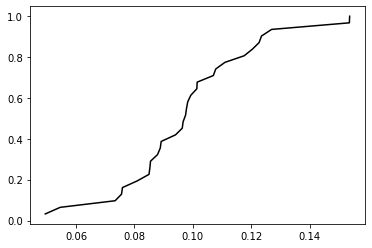

In [474]:
plt.plot(list(dic_n.values()), list(dic_n.keys()), color='black')

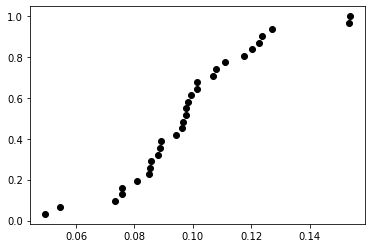

In [475]:
plt.plot(list(dic_n.values()), list(dic_n.keys()), "o", color='black');

In [452]:
import seaborn as sns

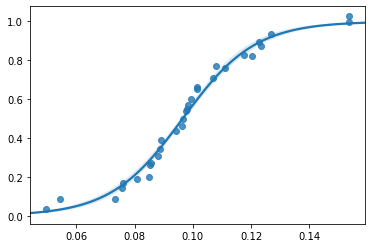

In [477]:
ax = sns.regplot(x = list(dic_n.values()), y=list(dic_n.keys()), logistic=True, n_boot=500, y_jitter=.03)               

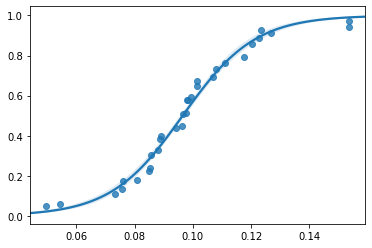

In [476]:
ax = sns.regplot(x = list(dic_n.values()), y=list(dic_n.keys()), logistic=True, n_boot=5000, y_jitter=.03)               

In [501]:
x = list(dic_n.values())

In [502]:
y = list(dic_n.keys())

In [504]:
from scipy import interpolate

In [505]:
f = interpolate.interp1d(x, y)

In [515]:
f([0.95])

ValueError: A value in x_new is above the interpolation range.

In [510]:
ynew = f(x)   # use interpolation function returned by `interp1d`

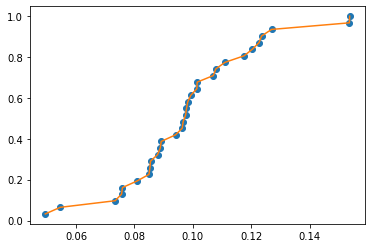

In [519]:
plt.plot(x, y, 'o', x, y, '-')
plt.show()

array([0.03225806, 0.06451613, 0.09677419, 0.12903226, 0.16129032,
       0.19354839, 0.22580645, 0.25806452, 0.29032258, 0.32258065,
       0.35483871, 0.38709677, 0.41935484, 0.4516129 , 0.48387097,
       0.51612903, 0.5483871 , 0.58064516, 0.61290323, 0.64516129,
       0.67741935, 0.70967742, 0.74193548, 0.77419355, 0.80645161,
       0.83870968, 0.87096774, 0.90322581, 0.93548387, 0.96774194,
       1.        ])

In [471]:
ent_csa_df.sort_values(by = 'percent_womyn', ascending = False)

,funding,jobs_created,patents,ipo,female,ent,percent_womyn
csa_code,,,,,,,
267.0,1170000,100.0,0.0,0,2,2,1.000000
"Saint Cloud, Minnesota",2200000,10.0,0.0,0,1,1,1.000000
"East Syracuse, New York",2666404,10.0,0.0,0,1,1,1.000000
"Trussville, Alabama",25000,50.0,11.0,0,1,1,1.000000
"Illinois City, Illinois",810246,0.0,0.0,0,1,1,1.000000
"Ivyland, Pennsylvania",22378442,20.0,0.0,0,2,2,1.000000
"Santa Rosa Beach, Florida",2400000,0.0,0.0,0,1,1,1.000000
"Warwick, New York",0,10.0,0.0,0,1,1,1.000000
"Woodbury, Connecticut",0,10.0,7.0,0,1,1,1.000000


In [462]:
ent_csa_df['percent_womyn' > 14.0]

TypeError: '>' not supported between instances of 'str' and 'float'

In [458]:
x_train = list(dic_n.values())

In [459]:
y_train = list(dic_n.keys())

In [460]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(x_train, y_train)

#
#y_pred=logreg.predict(X_test)

/Users/dhyanna/socos/impact-index/env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: Expected 2D array, got 1D array instead:
array=[0.04945514 0.05457542 0.07338462 0.07557902 0.07589251 0.08090829
 0.08498362 0.0852971  0.08550609 0.08790949 0.08884995 0.08916344
 0.09407473 0.09637363 0.09668711 0.09752308 0.09783656 0.09825455
 0.0992995  0.10138941 0.10149391 0.10703217 0.10786813 0.111003
 0.11758621 0.12040759 0.12270649 0.12354246 0.12699081 0.15363716
 0.15374166].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [415]:
counts

array([0.06451613, 0.09677419, 0.09677419, 0.09677419, 0.09677419,
       0.09677419, 0.12903226, 0.19354839, 0.19354839, 0.22580645,
       0.32258065, 0.41935484, 0.4516129 , 0.58064516, 0.67741935,
       0.70967742, 0.77419355, 0.80645161, 0.80645161, 0.83870968,
       0.87096774, 0.93548387, 0.96774194, 0.96774194, 0.96774194,
       0.96774194, 0.96774194, 0.96774194, 0.96774194, 1.        ])

In [404]:
np.cumsum(ser)

5      0.094281
11     0.192228
18     0.293923
20     0.401936
21     0.451523
22     0.536630
26     0.591317
27     0.667340
30     0.756674
32     0.853560
48     0.941588
51     1.015117
57     1.168963
63     1.280074
67     1.397857
71     1.495559
74     1.619226
77     1.704669
81     1.785750
83     1.908645
87     2.035764
90     2.156352
91     2.232110
92     2.330555
94     2.416270
98     2.517792
105    2.614284
109    2.663634
111    2.763080
112    2.870252
121    2.959229
Name: percent_womyn, dtype: float64

In [397]:
cum_dist = np.linspace(0.,1.,len(ser))
ser_cdf = pd.Series(cum_dist, index=ser)

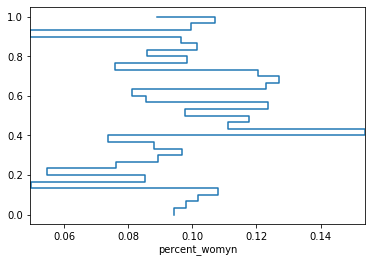

In [398]:
ser_cdf.plot(drawstyle='steps')

In [396]:
np.cumsum(ser)

5      0.094281
11     0.192228
18     0.293923
20     0.401936
21     0.451523
22     0.536630
26     0.591317
27     0.667340
30     0.756674
32     0.853560
48     0.941588
51     1.015117
57     1.168963
63     1.280074
67     1.397857
71     1.495559
74     1.619226
77     1.704669
81     1.785750
83     1.908645
87     2.035764
90     2.156352
91     2.232110
92     2.330555
94     2.416270
98     2.517792
105    2.614284
109    2.663634
111    2.763080
112    2.870252
121    2.959229
Name: percent_womyn, dtype: float64

In [394]:
np.histogram(cumulative)

(array([3, 4, 4, 2, 3, 3, 2, 3, 4, 3]),
 array([0.0942813 , 0.38077607, 0.66727085, 0.95376562, 1.24026039,
        1.52675517, 1.81324994, 2.09974472, 2.38623949, 2.67273426,
        2.95922904]))

(array([3., 4., 4., 2., 3., 3., 2., 3., 4., 3.]),
 array([0.0942813 , 0.38077607, 0.66727085, 0.95376562, 1.24026039,
        1.52675517, 1.81324994, 2.09974472, 2.38623949, 2.67273426,
        2.95922904]),
 <a list of 10 Patch objects>)

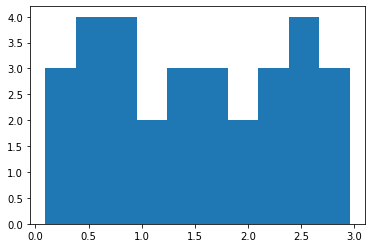

In [395]:
plt.hist(cumulative)

In [104]:
len(ent_df[ent_df.ent >= 100])

31

In [61]:
entrepreneur_df.shape

(38497, 20)

In [62]:
2830/38497

0.07351222173156349

In [60]:
int(ent_csa_df.index)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'Index'

In [65]:
len(entrepreneur_df[entrepreneur_df['first_name'] == 'dr.'])

52

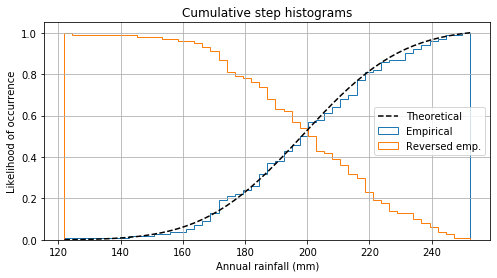

In [408]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(19680801)

mu = 200
sigma = 25
n_bins = 50
x = np.random.normal(mu, sigma, size=100)

fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist(x, n_bins, density=True, histtype='step',
                           cumulative=True, label='Empirical')

# Add a line showing the expected distribution.
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
y = y.cumsum()
y /= y[-1]

ax.plot(bins, y, 'k--', linewidth=1.5, label='Theoretical')

# Overlay a reversed cumulative histogram.
ax.hist(x, bins=bins, density=True, histtype='step', cumulative=-1,
        label='Reversed emp.')

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Cumulative step histograms')
ax.set_xlabel('Annual rainfall (mm)')
ax.set_ylabel('Likelihood of occurrence')

plt.show()

In [410]:
y

array([3.23856949e-04, 7.69984831e-04, 1.37789161e-03, 2.19727295e-03,
       3.28973568e-03, 4.73051897e-03, 6.61010480e-03, 9.03558166e-03,
       1.21316004e-02, 1.60407428e-02, 2.09231150e-02, 2.69549817e-02,
       3.43262814e-02, 4.32369002e-02, 5.38916471e-02, 6.64939490e-02,
       8.12383826e-02, 9.83022621e-02, 1.17836611e-01, 1.39956939e-01,
       1.64734334e-01, 1.92187424e-01, 2.22275766e-01, 2.54895227e-01,
       2.89875787e-01, 3.26982135e-01, 3.65917221e-01, 4.06328774e-01,
       4.47818580e-01, 4.89954137e-01, 5.32282117e-01, 5.74342946e-01,
       6.15685717e-01, 6.55882640e-01, 6.94542252e-01, 7.31320723e-01,
       7.65930699e-01, 7.98147351e-01, 8.27811438e-01, 8.54829428e-01,
       8.79170884e-01, 9.00863482e-01, 9.19986129e-01, 9.36660749e-01,
       9.51043281e-01, 9.63314458e-01, 9.73670853e-01, 9.82316597e-01,
       9.89456095e-01, 9.95287920e-01, 1.00000000e+00])

In [78]:
len(entrepreneur_df[entrepreneur_df['first_name'] == 'doc']) #or md

1

In [ ]:
df.hist(column='session_duration_seconds')

In [72]:
len(entrepreneur_df[entrepreneur_df['first_name'] == 'prof.'])

2

In [73]:
# looking up different names

In [42]:
unk_df = entrepreneur_df[entrepreneur_df['gender'] == 'unknown']
unk_names = list(unk_df.index)

In [44]:
new_df = []

In [47]:
for i in entrepreneur_df.index:
    if entrepreneur_df.at[i, 'csa_code'] == '104.0':
        new_df.append(i)

In [54]:
len(new_df)

21

In [122]:
entrepreneur_df.columns

Index(['name', 'company_name', 'crunchbase_uuid', 'crunchbase_permalink',
       'funding', 'jobs_created', 'patents', 'ipo', 'city', 'state',
       'state_abbrev', 'cbsa_code', 'csa_code', 'gender', 'lgbtq',
       'race_ethnicity', 'startout_id', 'first_name', 'female', 'ent'],
      dtype='object')

In [51]:
ent_cols = list(entrepreneur_df.columns)

In [146]:
# Creating an empty Dataframe with column names only
csa_df = pd.DataFrame(columns = new_cols)

In [124]:
new_cols = ['name', 'company_name', 'funding', 'jobs_created', 'patents', 'ipo', 'city', 'state','csa_code', 'gender', 'lgbtq']

In [126]:
csa_df

,name,company_name,funding,jobs_created,patents,ipo,city,state,csa_code,gender,lgbtq


In [53]:
# Append rows in Empty Dataframe by adding dictionaries
csa_df = csa_df.append({'User_ID': 23, 'UserName': 'Riti', 'Action': 'Login'}, ignore_index=True)
csa_df = csa_df.append({'User_ID': 24, 'UserName': 'Aadi', 'Action': 'Logout'}, ignore_index=True)
csa_df = csa_df.append({'User_ID': 25, 'UserName': 'Jack', 'Action': 'Login'}, ignore_index=True)

,name,company_name,crunchbase_uuid,crunchbase_permalink,funding,jobs_created,patents,ipo,city,state,state_abbrev,cbsa_code,csa_code,gender,lgbtq,race_ethnicity,startout_id,first_name,female,ent


In [136]:
ent_df = ent_df.set_index('csa_code') 

In [118]:
entrepreneur_df.columns

Index(['name', 'company_name', 'crunchbase_uuid', 'crunchbase_permalink',
       'funding', 'jobs_created', 'patents', 'ipo', 'city', 'state',
       'state_abbrev', 'cbsa_code', 'csa_code', 'gender', 'lgbtq',
       'race_ethnicity', 'startout_id', 'first_name', 'female', 'ent'],
      dtype='object')

In [127]:
for i in entrepreneur_df.index:
    name = entrepreneur_df.at[i, 'name']
    company_name = entrepreneur_df.at[i, 'company_name']
    funding = entrepreneur_df.at[i, 'funding']
    jobs_created = entrepreneur_df.at[i, 'jobs_created']
    patents = entrepreneur_df.at[i, 'patents']
    ipo = entrepreneur_df.at[i, 'ipo']
    city = entrepreneur_df.at[i, 'city']
    state = entrepreneur_df.at[i, 'state']
    csa_code = entrepreneur_df.at[i, 'csa_code']
    gender = entrepreneur_df.at[i, 'gender']
    lgbtq = entrepreneur_df.at[i, 'lgbtq']
    
    if csa_code == '104.0':
        new_dict = {}
        new_dict['name'] = name
        new_dict['company_name'] = company_name
        new_dict['funding'] = funding
        new_dict['jobs_created'] = jobs_created
        new_dict['patents'] = patents
        new_dict['ipo'] = ipo
        new_dict['csa_code'] = csa_code
        new_dict['gender'] = gender
        print(new_dict)
        csa_df = csa_df.append(new_dict, ignore_index=True)

{'name': 'Steve Wightman', 'funding': 2500000, 'jobs_created': 50.0, 'patents': 0.0, 'ipo': 0, 'csa_code': '104.0', 'gender': 'Male'}
{'name': 'Shreefal Mehta', 'funding': 5702907, 'jobs_created': 50.0, 'patents': 0.0, 'ipo': 0, 'csa_code': '104.0', 'gender': 'unknown'}
{'name': 'Colleen A. Costello', 'funding': 2500000, 'jobs_created': 50.0, 'patents': 4.0, 'ipo': 0, 'csa_code': '104.0', 'gender': 'Female'}
{'name': 'James W. Peterson', 'funding': 2500000, 'jobs_created': 50.0, 'patents': 4.0, 'ipo': 0, 'csa_code': '104.0', 'gender': 'Male'}
{'name': 'Dave Geoghegan', 'funding': 1300000, 'jobs_created': 50.0, 'patents': 0.0, 'ipo': 0, 'csa_code': '104.0', 'gender': 'Male'}
{'name': 'Bob Godgart', 'funding': 1300000, 'jobs_created': 50.0, 'patents': 0.0, 'ipo': 0, 'csa_code': '104.0', 'gender': 'Male'}
{'name': 'Jay McBain', 'funding': 1300000, 'jobs_created': 50.0, 'patents': 0.0, 'ipo': 0, 'csa_code': '104.0', 'gender': 'Male'}
{'name': 'David Geoghegan', 'funding': 1300000, 'jobs_cr

In [245]:
#472
csa_472 = entrepreneur_df[entrepreneur_df.csa_code == '472.0']

In [133]:
csa_104 = entrepreneur_df[entrepreneur_df.csa_code == '104.0']

In [300]:
#148.0
csa_148 = entrepreneur_df[entrepreneur_df.csa_code == '104.0']

In [134]:
csa_104

,name,company_name,crunchbase_uuid,crunchbase_permalink,funding,jobs_created,patents,ipo,city,state,state_abbrev,cbsa_code,csa_code,gender,lgbtq,race_ethnicity,startout_id,first_name,female,ent
238,Steve Wightman,BuildPay,7d9c9b657bc5414c872b33c8b4552b7e,buildpay,2500000,50.0,0.0,0,Troy,New York,NY,10580.0,104.0,Male,None,None,None,steve,0,1
239,Shreefal Mehta,PBC Tech,5bf88c84072b463da0ee8e1ef96b2502,pbc-tech,5702907,50.0,0.0,0,Troy,New York,NY,10580.0,104.0,unknown,None,None,None,shreefal,0,1
240,Colleen A. Costello,Vital Vio,8a09a6c7e8619944f9eafdc8b358a3ed,vital-vio,2500000,50.0,4.0,0,Troy,New York,NY,10580.0,104.0,Female,None,None,None,colleen,1,1
241,James W. Peterson,Vital Vio,8a09a6c7e8619944f9eafdc8b358a3ed,vital-vio,2500000,50.0,4.0,0,Troy,New York,NY,10580.0,104.0,Male,None,None,None,james,0,1
244,Dave Geoghegan,ChannelEyes,87f744d185b68c0c128fcbf368109d05,channeleyes,1300000,50.0,0.0,0,Troy,New York,NY,10580.0,104.0,Male,None,None,None,dave,0,1
245,Bob Godgart,ChannelEyes,87f744d185b68c0c128fcbf368109d05,channeleyes,1300000,50.0,0.0,0,Troy,New York,NY,10580.0,104.0,Male,None,None,None,bob,0,1
246,Jay McBain,ChannelEyes,87f744d185b68c0c128fcbf368109d05,channeleyes,1300000,50.0,0.0,0,Troy,New York,NY,10580.0,104.0,Male,None,None,None,jay,0,1
247,David Geoghegan,ChannelEyes,87f744d185b68c0c128fcbf368109d05,channeleyes,1300000,50.0,0.0,0,Troy,New York,NY,10580.0,104.0,Male,None,None,None,david,0,1
248,Shari Godgart,ChannelEyes,87f744d185b68c0c128fcbf368109d05,channeleyes,1300000,50.0,0.0,0,Troy,New York,NY,10580.0,104.0,unknown,None,None,None,shari,0,1
249,Karthik Bala,Velan Studios,baa130a5e5b1537cf412b3108f12f7a0,velan-studios,7000000,50.0,0.0,0,Troy,New York,NY,10580.0,104.0,Male,None,None,None,karthik,0,1


In [142]:
ent_df.index

Float64Index([104.0, 106.0, 107.0, 108.0, 120.0, 122.0, 140.0, 142.0, 144.0,
              146.0,
              ...
              518.0, 532.0, 534.0, 536.0, 538.0, 545.0, 548.0, 554.0, 556.0,
              566.0],
             dtype='float64', name='csa_code', length=125)

In [143]:
#set index as CSA code as integer, and finding the percent_womyn for each
ent_df.loc[104.0, 'percent_womyn']

0.14285714285714285

In [147]:
csa_104_hist = pd.DataFrame(columns = csa_104.columns)

In [148]:
percent_womyn = ent_df.loc[104.0, 'percent_womyn']

In [151]:
csa_104.reset_index(inplace=True)
csa_104

,level_0,index,name,company_name,crunchbase_uuid,crunchbase_permalink,funding,jobs_created,patents,ipo,...,state_abbrev,cbsa_code,csa_code,gender,lgbtq,race_ethnicity,startout_id,first_name,female,ent
0,0,238,Steve Wightman,BuildPay,7d9c9b657bc5414c872b33c8b4552b7e,buildpay,2500000,50.0,0.0,0,...,NY,10580.0,104.0,Male,None,None,None,steve,0,1
1,1,239,Shreefal Mehta,PBC Tech,5bf88c84072b463da0ee8e1ef96b2502,pbc-tech,5702907,50.0,0.0,0,...,NY,10580.0,104.0,unknown,None,None,None,shreefal,0,1
2,2,240,Colleen A. Costello,Vital Vio,8a09a6c7e8619944f9eafdc8b358a3ed,vital-vio,2500000,50.0,4.0,0,...,NY,10580.0,104.0,Female,None,None,None,colleen,1,1
3,3,241,James W. Peterson,Vital Vio,8a09a6c7e8619944f9eafdc8b358a3ed,vital-vio,2500000,50.0,4.0,0,...,NY,10580.0,104.0,Male,None,None,None,james,0,1
4,4,244,Dave Geoghegan,ChannelEyes,87f744d185b68c0c128fcbf368109d05,channeleyes,1300000,50.0,0.0,0,...,NY,10580.0,104.0,Male,None,None,None,dave,0,1
5,5,245,Bob Godgart,ChannelEyes,87f744d185b68c0c128fcbf368109d05,channeleyes,1300000,50.0,0.0,0,...,NY,10580.0,104.0,Male,None,None,None,bob,0,1
6,6,246,Jay McBain,ChannelEyes,87f744d185b68c0c128fcbf368109d05,channeleyes,1300000,50.0,0.0,0,...,NY,10580.0,104.0,Male,None,None,None,jay,0,1
7,7,247,David Geoghegan,ChannelEyes,87f744d185b68c0c128fcbf368109d05,channeleyes,1300000,50.0,0.0,0,...,NY,10580.0,104.0,Male,None,None,None,david,0,1
8,8,248,Shari Godgart,ChannelEyes,87f744d185b68c0c128fcbf368109d05,channeleyes,1300000,50.0,0.0,0,...,NY,10580.0,104.0,unknown,None,None,None,shari,0,1
9,9,249,Karthik Bala,Velan Studios,baa130a5e5b1537cf412b3108f12f7a0,velan-studios,7000000,50.0,0.0,0,...,NY,10580.0,104.0,Male,None,None,None,karthik,0,1


In [185]:
num_to_sample = np.round(percent_womyn * csa_104.shape[0])
num_to_sample = int(num_to_sample)

In [186]:
length = csa_104.shape[0]
length = int(length)

In [215]:
index_to_sample = np.random.choice(length, num_to_sample, replace=False)

In [218]:
index_to_sample = list(index_to_sample)

In [239]:
for i in index_to_sample:
    name = csa_104.at[i, 'name']
    company_name = csa_104.at[i, 'company_name']
    funding = csa_104.at[i, 'funding']
    jobs_created = csa_104.at[i, 'jobs_created']
    patents = csa_104.at[i, 'patents']
    ipo = csa_104.at[i, 'ipo']
    city = csa_104.at[i, 'city']
    state = csa_104.at[i, 'state']
    csa_code = csa_104.at[i, 'csa_code']
    gender = csa_104.at[i, 'gender']
    lgbtq = csa_104.at[i, 'lgbtq']
    
    if gender == 'unknown':
        new_dict = {}
        new_dict['name'] = name
        new_dict['company_name'] = company_name
        new_dict['funding'] = funding
        new_dict['jobs_created'] = jobs_created
        new_dict['patents'] = patents
        new_dict['ipo'] = ipo
        new_dict['csa_code'] = csa_code
        new_dict['gender'] = gender
        print(new_dict)
        csa_104_hist = csa_104_hist.append(new_dict, ignore_index=True)

{'name': 'Shari Godgart', 'company_name': 'ChannelEyes', 'funding': 1300000, 'jobs_created': 50.0, 'patents': 0.0, 'ipo': 0, 'csa_code': '104.0', 'gender': 'unknown'}


In [230]:
csa_104_hist

,name,company_name,funding,jobs_created,patents,ipo,city,state,csa_code,gender,lgbtq
0,Adam Bronte,Furlocity,1545000,10.0,0.0,0,NaN,NaN,104.0,Male,NaN
1,David Geoghegan,ChannelEyes,1300000,50.0,0.0,0,NaN,NaN,104.0,Male,NaN
2,Shari Godgart,ChannelEyes,1300000,50.0,0.0,0,NaN,NaN,104.0,unknown,NaN
3,Adam Bronte,Furlocity,1545000,10.0,0.0,0,NaN,NaN,104.0,Male,NaN


In [210]:
np.random.choice(2, 2, replace=False)

array([1, 0])

In [211]:
csa_df

,name,company_name,funding,jobs_created,patents,ipo,city,state,csa_code,gender,lgbtq


In [235]:
unk_index = list(csa_104[csa_104.gender == 'unknown'].index)

In [243]:
np.round(percent_womyn * len(unk_index))

0.0

In [299]:
csa_472_indivs = csa_472[csa_472.gender == 'unknown']

In [247]:
csa_472_unk = list(csa_472[csa_472.gender == 'unknown'].index)

In [267]:
csa_472_unk

[380, 21467, 25477, 25490, 37828, 37829, 37833]

In [251]:
number_to_sample = int(np.round(percent_womyn * len(csa_472_unk)))

In [252]:
number_to_sample

1

In [268]:
num_list = list(np.random.choice(csa_472_unk, number_to_sample, replace = False))
num_list

[37829]

In [301]:
csa_472

,name,company_name,crunchbase_uuid,crunchbase_permalink,funding,jobs_created,patents,ipo,city,state,state_abbrev,cbsa_code,csa_code,gender,lgbtq,race_ethnicity,startout_id,first_name,female,ent
370,Tim Colin,Sostena,ccf7444230c2d1af6b083dbb9705a58d,sostena,8100000,NaN,0.0,0,Davis,California,CA,40900.0,472.0,Male,None,None,None,tim,0,1
371,Marcus Meadows-Smith,BioConsortia,1de18b32ff0bbce3e1a29c299f9e2fc6,bioconsortia,37000000,50.0,0.0,0,Davis,California,CA,40900.0,472.0,Male,None,None,None,marcus,0,1
372,Christina Huben,BioConsortia,1de18b32ff0bbce3e1a29c299f9e2fc6,bioconsortia,37000000,50.0,0.0,0,Davis,California,CA,40900.0,472.0,Female,None,None,None,christina,1,1
373,Mike G. Hart,Sierra Energy,ea565abdf66945e6973218b3cc481c40,sierra-energy,33000000,NaN,0.0,0,Davis,California,CA,40900.0,472.0,Male,None,None,None,mike,0,1
374,Stephen Dueker,Vitalea Science,85dab58de5811b531e80463d6f647a87,vitalea-science,260000,50.0,1.0,0,Davis,California,CA,40900.0,472.0,Male,None,None,None,stephen,0,1
375,Le Thuy Vuong,Vitalea Science,85dab58de5811b531e80463d6f647a87,vitalea-science,260000,50.0,1.0,0,Davis,California,CA,40900.0,472.0,Female,None,None,None,le,1,1
376,Andrew Sterling,Engage3,73c454252d8c9d47e87a02f89ecf459b,engage3-solution,24000000,50.0,0.0,0,Davis,California,CA,40900.0,472.0,Male,None,None,None,andrew,0,1
377,Ken Ouimet,Engage3,73c454252d8c9d47e87a02f89ecf459b,engage3-solution,24000000,50.0,0.0,0,Davis,California,CA,40900.0,472.0,Male,None,None,None,ken,0,1
378,Tim Ouimet,Engage3,73c454252d8c9d47e87a02f89ecf459b,engage3-solution,24000000,50.0,0.0,0,Davis,California,CA,40900.0,472.0,Male,None,None,None,tim,0,1
379,Daniela Barile,Evolve Biosystems,83e54a307300c95af459892e03217322,evolve-biosystems,69000000,50.0,0.0,0,Davis,California,CA,40900.0,472.0,Female,None,None,None,daniela,1,1


In [297]:
hist_list = []
for i in range(100000):
    num = list(np.random.choice(csa_472_unk, number_to_sample, replace = False))
    hist_list = hist_list + num

In [302]:
new_hist_list = []
for i in hist_list:
    funding = csa_472.at[i, 'funding']
    new_hist_list.append(funding)

In [314]:
new_hist_list

[250000,
 2139983,
 6800000,
 0,
 65000000,
 69000000,
 65000000,
 6800000,
 250000,
 6800000,
 65000000,
 0,
 6800000,
 2139983,
 69000000,
 0,
 2139983,
 2139983,
 69000000,
 0,
 6800000,
 2139983,
 2139983,
 0,
 65000000,
 65000000,
 250000,
 65000000,
 65000000,
 65000000,
 65000000,
 2139983,
 2139983,
 250000,
 0,
 250000,
 6800000,
 65000000,
 0,
 2139983,
 65000000,
 65000000,
 69000000,
 6800000,
 250000,
 2139983,
 65000000,
 2139983,
 65000000,
 2139983,
 0,
 6800000,
 65000000,
 6800000,
 69000000,
 0,
 65000000,
 6800000,
 6800000,
 65000000,
 250000,
 65000000,
 250000,
 65000000,
 65000000,
 6800000,
 69000000,
 65000000,
 69000000,
 65000000,
 250000,
 2139983,
 250000,
 69000000,
 6800000,
 69000000,
 65000000,
 65000000,
 250000,
 69000000,
 65000000,
 0,
 6800000,
 250000,
 6800000,
 65000000,
 6800000,
 2139983,
 2139983,
 0,
 2139983,
 250000,
 250000,
 65000000,
 65000000,
 0,
 6800000,
 6800000,
 65000000,
 2139983,
 69000000,
 65000000,
 69000000,
 0,
 65000000,

(array([43127.,     0., 14136.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0., 28486.,
        14251.]),
 array([       0.,  2760000.,  5520000.,  8280000., 11040000., 13800000.,
        16560000., 19320000., 22080000., 24840000., 27600000., 30360000.,
        33120000., 35880000., 38640000., 41400000., 44160000., 46920000.,
        49680000., 52440000., 55200000., 57960000., 60720000., 63480000.,
        66240000., 69000000.]),
 <a list of 25 Patch objects>)

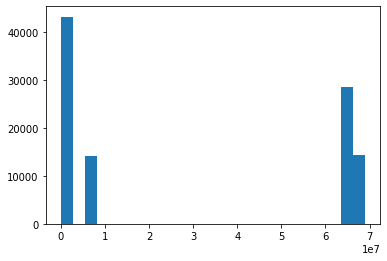

In [316]:
plt.hist(new_hist_list, bins = 'auto')

In [322]:
entrepreneur_df.gender.value_counts()

Male       31693
Female      3921
unknown     2883
Name: gender, dtype: int64

In [365]:
csa_206 = entrepreneur_df[(entrepreneur_df.csa_code == '206.0') & (csa_206.gender == 'unknown')]

In [367]:
num_unk_206 = len(csa_206)

In [369]:
s = np.random.uniform(0,1)
s

0.9463797117078119

In [370]:
percent_womyn_206 = ent_csa_df.at['206.0','percent_womyn']

In [371]:
csa_206_funding_unk = []
for i in csa_206.index:
    if s > percent_womyn_206:
        csa_206_funding_unk.append(csa_206.at[i, 'funding'])

(array([15.,  1.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([       0.        ,  9955180.4       , 19910360.8       ,
        29865541.2       , 39820721.6       , 49775902.        ,
        59731082.40000001, 69686262.8       , 79641443.2       ,
        89596623.60000001, 99551804.        ]),
 <a list of 10 Patch objects>)

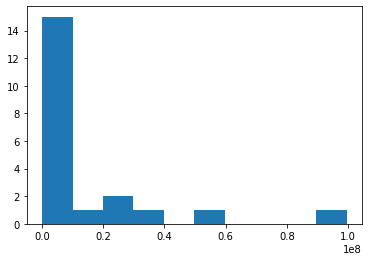

In [372]:
plt.hist(csa_206_funding_unk)

In [378]:
np.histogram(csa_206_funding_unk, bins='auto')

(array([15,  1,  2,  1,  0,  1,  0,  0,  0,  0,  1]),
 array([       0.,  9050164., 18100328., 27150492., 36200656., 45250820.,
        54300984., 63351148., 72401312., 81451476., 90501640., 99551804.]))

In [373]:
values, base = np.histogram(csa_206_funding_unk, bins='auto')

In [377]:
values

array([15,  1,  2,  1,  0,  1,  0,  0,  0,  0,  1])

In [374]:
cumulative = np.cumsum(values)

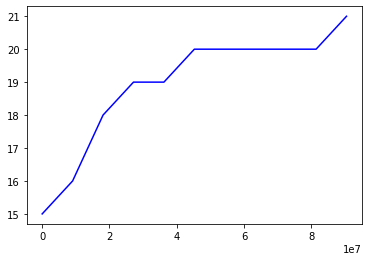

In [375]:
plt.plot(base[:-1], cumulative, c='blue')

In [376]:
cumulative

array([15, 16, 18, 19, 19, 20, 20, 20, 20, 20, 21])

In [ ]:
#for i in range(1000):
for m in range(num_unk_206):
    

In [323]:
#206.0
csa_206 = entrepreneur_df[entrepreneur_df.csa_code == '206.0'] # & entrepreneur_df.gender == 'unknown']

In [326]:
csa_206_unk = csa_206[csa_206.gender == 'unknown']

In [338]:
csa_206_unk_indexes = list(csa_206_unk.index)

In [333]:
ent_csa_df.set_index('csa_code', inplace=True)

In [337]:
percent_womyn_206 = ent_csa_df.at['206.0','percent_womyn']

In [342]:
num_to_sample = int(percent_womyn_206 * len(csa_206_unk_indexes))

In [343]:
# choose the index numbers from ent df randomly
hist_list = []
for i in range(100000):
    num = list(np.random.choice(csa_206_unk_indexes, num_to_sample, replace = False))
    hist_list = hist_list + num

In [344]:
len(hist_list)

100000

In [ ]:
#hist list are the indexes we want to sample from

In [345]:
csa_206_unk_sampled = []
for i in hist_list:
    funding = csa_206_unk.at[i, 'funding']
    csa_206_unk_sampled.append(funding)

In [381]:
import numpy as np
hist, bin_edges = np.histogram(np.random.randint(0,10,100), density=True)
bin_edges
#array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ])

/Users/dhyanna/socos/impact-index/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ])

WARNING:

/Users/dhyanna/socos/impact-index/env/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.

In [382]:
hist

array([0.08888889, 0.11111111, 0.1       , 0.1       , 0.16666667,
       0.12222222, 0.07777778, 0.11111111, 0.15555556, 0.07777778])

In [383]:
np.cumsum(hist)

array([0.08888889, 0.2       , 0.3       , 0.4       , 0.56666667,
       0.68888889, 0.76666667, 0.87777778, 1.03333333, 1.11111111])

In [385]:
from scipy import stats

In [386]:
stats.cumfreq(csa_206_unk_sampled, numbins=25)

CumfreqResult(cumcount=array([ 28485.,  61883.,  71496.,  71496.,  76262.,  85697.,  85697.,
        85697.,  85697.,  90488.,  90488.,  90488.,  90488.,  95215.,
        95215.,  95215.,  95215.,  95215.,  95215.,  95215.,  95215.,
        95215.,  95215.,  95215., 100000.]), lowerlimit=-2073995.9166666667, binsize=4147991.833333334, extrapoints=0)

([array([ 0.,  0.,  0., 25.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])],
 array([-2073995.91666667, -1451797.14166667,  -829598.36666667,
         -207399.59166667,   414799.18333333,  1036997.95833333,
         1659196.73333333,  2281395.50833333,  2903594.28333333,
         3525793.05833333,  4147991.83333333]),
 <a list of 4 Lists of Patches objects>)

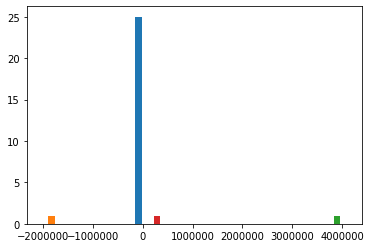

In [387]:
plt.hist(stats.cumfreq(csa_206_unk_sampled, numbins=25))

In [ ]:
>>> hist
#array([ 0.14444444,  0.11111111,  0.11111111,  0.1       ,  0.1       ,
        0.14444444,  0.14444444,  0.08888889,  0.03333333,  0.13333333])
>>> np.cumsum(hist)
#array([ 0.14444444,  0.25555556,  0.36666667,  0.46666667,  0.56666667,
        0.71111111,  0.85555556,  0.94444444,  0.97777778,  1.11111111])

(array([23717.,     0.,     0.,  4768.,  9418.,  4820.,  4843.,  9652.,
            0.,  4665.,     0.,     0.,     0.,     0.,  9613.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,  4766.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
         9435.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  4791.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,  4727.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0., 

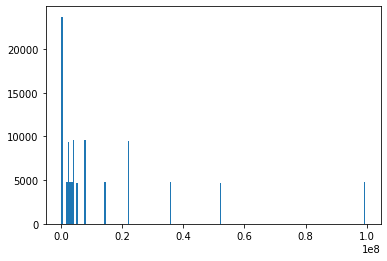

In [346]:
plt.hist(csa_206_unk_sampled, bins = 'auto')

In [351]:
np.mean(csa_206_unk_sampled)

13732125.72039

In [352]:
np.std(csa_206_unk_sampled)

23282948.361306574

In [353]:
13732125 - 23282948

-9550823

In [306]:
np.histogram(new_hist_list, bins = 'auto')

(array([43127,     0, 14136,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0, 28486, 14251]),
 array([       0.,  2760000.,  5520000.,  8280000., 11040000., 13800000.,
        16560000., 19320000., 22080000., 24840000., 27600000., 30360000.,
        33120000., 35880000., 38640000., 41400000., 44160000., 46920000.,
        49680000., 52440000., 55200000., 57960000., 60720000., 63480000.,
        66240000., 69000000.]))

In [303]:
for i in hist_list:
    funding = csa_472.at[i, 'funding']
    
    new_dict = {}
    new_dict['funding'] = funding
    
    new_df = new_df.append(new_dict, ignore_index=True)

KeyboardInterrupt: 

In [ ]:
new_df.hist('funding', bins = 30)

In [ ]:
new_df.funding.describe()

In [ ]:
new_df.funding.mean()

In [294]:
conf_interval = 1.96 * new_df.funding.std()

In [295]:
new_df.funding.mean() + conf_interval

92027542.84222992

In [296]:
new_df.funding.mean() - conf_interval

-32586590.84547316

In [274]:
new_df = pd.DataFrame()

In [273]:
csa_df

,name,company_name,funding,jobs_created,patents,ipo,city,state,csa_code,gender,lgbtq


In [ ]:
def make_histogram(csa_df):
    new_csa = 
    for i in csa_df.index:
        name = csa_df.at[i, 'name']
        company_name = csa_df.at[i, 'company_name']
        funding = csa_df.at[i, 'funding']
        jobs_created = csa_df.at[i, 'jobs_created']
        patents = csa_df.at[i, 'patents']
        ipo = csa_df.at[i, 'ipo']
        city = csa_df.at[i, 'city']
        state = csa_df.at[i, 'state']
        csa_code =csa_df.at[i, 'csa_code']
        gender = csa_df.at[i, 'gender']
        lgbtq = csa_df.at[i, 'lgbtq']

        if csa_code == '104.0':
            new_dict = {}
            new_dict['name'] = name
            new_dict['company_name'] = company_name
            new_dict['funding'] = funding
            new_dict['jobs_created'] = jobs_created
            new_dict['patents'] = patents
            new_dict['ipo'] = ipo
            new_dict['csa_code'] = csa_code
            new_dict['gender'] = gender
            print(new_dict)
            csa_df = csa_df.append(new_dict, ignore_index=True)

In [ ]:
# Unknown names to fem 
unk_to_fem = np.random.choice(
    [x for x in unk_names],
    int((np.round(percent_fem*len(unk_names), 4))),
    replace=False
)

In [ ]:
# Extrapolating to the unknowns (which include androgenous)
male_num = entrepreneur_df['gender'].value_counts()['Male']
female_num = entrepreneur_df['gender'].value_counts()['Female']
unknown_num = entrepreneur_df['gender'].value_counts()['unknown']
percent_fem = female_num / (female_num + male_num)

unk_df = entrepreneur_df[entrepreneur_df['gender'] == 'unknown']
unk_names = list(unk_df.index)

# Unknown names to fem 
unk_to_fem = np.random.choice(
    [x for x in unk_names],
    int((np.round(percent_fem*len(unk_names), 4))),
    replace=False
)

for i in unk_to_fem:
    entrepreneur_df.at[i, 'gender'] = 'Female'   

unk_to_masc = set(unk_names) - set(unk_to_fem)

for i in unk_to_masc:
    entrepreneur_df.at[i, 'gender'] = 'Male'

# Calculating ratios
print(entrepreneur_df['gender'].value_counts())

entrepreneur_df.to_csv(
        'gs://impact-index-shared-resources/data/processed/entrepreneur_gender_df.csv',
        index=False
    )

return

In [ ]:
def main(event, context):
    """    
    - Create female names list
    - Create male names list
    - Create entrepreneur first name list
    - Identify gender of names (identify androgynous names, use gender guessor, Social Security data)
    """
    # Read in interim entrepreneur data from Storage
    entrepreneur_df = pd.read_csv('gs://impact-index-shared-resources/data/interim/{}/interim_entrepreneur_data.csv'.format(today))
    print('Entrepreneur data loaded. Shape:', entrepreneur_df.shape)

    # Create first name column
    for i in entrepreneur_df.index:
        entrepreneur_df.at[i, 'first_name'] = entrepreneur_df.at[i, 'name'].split(' ')[0].lower()

    # Query only null values
    null = entrepreneur_df[pd.isnull(entrepreneur_df['gender'])]

    # Get only unique names that are female, and aggregate the record number for each name
    female_names_query = """
    #standardSQL
    SELECT name, SUM(number) as records
    FROM `bigquery-public-data.usa_names.usa_1910_current`
    WHERE gender = 'F'
    GROUP BY name
    ORDER BY records DESC
    """
    

    # Takes only the names and turns it into a list
    female_names = female_names_df['name'].to_list()
    # Lowercase
    for i in range(len(female_names)):
        female_names[i] = female_names[i].lower()

    # Creates a separate list for male names because it is faster to use SQL than iterate through df
    male_names_query = """
    #standardSQL
    SELECT name, SUM(number) as records
    FROM `bigquery-public-data.usa_names.usa_1910_current`
    WHERE gender = 'M'
    GROUP BY name
    ORDER BY records DESC
    """

    male_names_query_job = client.query(male_names_query,location = 'US')
    male_names_result = male_names_query_job.result()

    # Create dataframe of male names
    male_names_df = male_names_result.to_dataframe()
    # Take only the male names and turns it into a list
    male_names = male_names_df['name'].to_list()
    # Lowercase
    for i in range(len(male_names)):
        male_names[i] =  male_names[i].lower()

    # Find androgynous names
    andro_names = (set(male_names).intersection(female_names))

    # Female names not in male list
    female_names = set(female_names) - set(male_names)

    # Male names not in female list
    male_names = set(male_names) - set(female_names)

    # Make everything into lists
    andro_names = list(andro_names)
    female_names = list(female_names)
    male_names = list(male_names)

    male_names_df = male_names_df.set_index('name')
    female_names_df = female_names_df.set_index('name')

    count_male = 0
    count_female = 0
    count_na = 0
    femme = []
    masc = []

    # Sort androgynous names
    for name in andro_names:
        name = name.capitalize()
        male_count = male_names_df.loc[name]['records']
        female_count = female_names_df.loc[name]['records']
        total = male_count + female_count
        percentage_male = round(male_count / total, 2)
        percentage_female = round(female_count / total, 2)
        if percentage_male >= 0.75:
            gender_assign = 'M'
            count_male += 1
            masc.append(name.lower())
        elif percentage_female >= 0.75:
            gender_assign = 'F'
            count_female += 1
            femme.append(name.lower())
        else:
            gender_assign = 'N/A'
            count_na += 1

        # x = 10 - len(str(male_count + female_count))
        # y = 10 - len(name)
        #debugging
        #print(name, y*' ', male_count, female_count, x*' ', ' | ', percentage_male, percentage_female, ' | ', gender_assign)

    # Combine lists
    female_names = female_names + femme
    male_names = male_names + masc

    # Unidentified names
    andro_ = set(andro_names) - set(masc)
    andro_ = set(andro_) - set(femme)

    # Assign gender from social security data
    female_count = 0
    male_count = 0
    andro_count = 0
    na_count = 0

    for i in null.index:
        name = null.at[i, 'first_name'].lower()

        if name in female_names:
            entrepreneur_df.at[i, 'gender'] = 'f'
            female_count += 1

        elif name in male_names:
            entrepreneur_df.at[i, 'gender'] = 'm'
            male_count += 1

        elif name in andro_:
            entrepreneur_df.at[i, 'gender'] = 'andro'
            andro_count += 1

        else:
            entrepreneur_df.at[i, 'gender'] = 'unknown'
            na_count += 1

    # Use the gender guesser
    d = gender.Detector()

    # Create additional checks for gender
    additional_female_names = [
        'Alika',
        'Ama',
        'Cibelle',
        'Kimberlina',
        'Leathia',
        'Shiri',
        'Lavena',
        'Tanjila',
        'Holley',
        'Anie',
        'Dionna',
        'Shanel',
        'Lakshya',
        'Shenda',
        'Madelena',
        'Kerranna',
        'Piya',
        'Paria',
        'Ylianna',
        'Ankita',
        'Isha',
        'Gabby',
        'Anjelika',
        'Nitha',
        'Adena',
        'Sumayah',
        'Louisea',
        'Cymphonique',
        'Charlyn',
        'Tari',
        'Graceann',
        'Kalia',
        'Annmarie',
        'Saira',
    ]
    additional_male_names = [
        'Deward',
        'Omkar',
        'Rohit',
        'Mohit',
        'Vik',
        'Vishal',
        'Obed',
        'Ashwin',
        'Ozel',
        'Umed',
        'Demetri',
        'Tripp',
        'Jean-Marc',
        'Laszlo',
        'Allon',
        'Rishi'
        'Francois',
        'Clarkson',
        'Siddharth',
        'Sidharth',
        'Anup',
        'Anoop',
        'Zac',
        'Andras',
        'Abhishek',
        'Dil-Domine',
        'Varun',
        'Abhinav',
        'Chaitanya',
        'Rishi',
        'Raghu',
        'Anurag',
        'Akshay',
        'Gaurav',
        'Kunal',
    ]

    # Create column 'female'
    entrepreneur_df['female'] = 0

    # Collect indices of female and androgynous names, and mark them as female
    female_names = []
    andy_names = []
    unk_names = []

    count_female = 0
    count_andy = 0
    count_unk = 0

    for i in entrepreneur_df.index:
        name = entrepreneur_df.at[i, 'first_name']
        if d.get_gender(name) == 'female':
            female_names.append([i, name])
            entrepreneur_df.at[i, 'female'] = 1
            count_female += 1
        elif d.get_gender(name) == 'mostly_female':
            female_names.append([i, name])
            entrepreneur_df.at[i, 'female'] = 1
            count_female += 1
        elif d.get_gender(name) == 'andy':
            andy_names.append([i, name])
            count_andy += 1
        elif d.get_gender(name) == 'unknown':
            if name in additional_female_names:
                female_names.append([i, name])
                entrepreneur_df.at[i, 'female'] = 1
                count_female += 1
            elif name in additional_male_names:
                pass
            else:
                unk_names.append([i, name])
                count_unk += 1
                

    for i in entrepreneur_df.index:
        # Over-ride the gender_guesser with the social security data
        if entrepreneur_df.at[i, 'gender'] == 'f' and entrepreneur_df.at[i, 'female'] == 0:
            entrepreneur_df.at[i, 'gender'] = 'Female'
        if entrepreneur_df.at[i, 'gender'] == 'm' and entrepreneur_df.at[i, 'female'] == 1:
            entrepreneur_df.at[i, 'gender'] = 'Male'

        # Assign female if both agree, and male if both agree
        if entrepreneur_df.at[i, 'gender'] == 'f' and entrepreneur_df.at[i, 'female'] == 1:
            entrepreneur_df.at[i, 'gender'] = 'Female'
        if entrepreneur_df.at[i, 'gender'] == 'm' and entrepreneur_df.at[i, 'female'] == 0:
            entrepreneur_df.at[i, 'gender'] = 'Male'

    # Extrapolating to the unknowns (which include androgenous)
    male_num = entrepreneur_df['gender'].value_counts()['Male']
    female_num = entrepreneur_df['gender'].value_counts()['Female']
    unknown_num = entrepreneur_df['gender'].value_counts()['unknown']
    percent_fem = female_num / (female_num + male_num)

    unk_df = entrepreneur_df[entrepreneur_df['gender'] == 'unknown']
    unk_names = list(unk_df.index)

    # Unknown names to fem 
    unk_to_fem = np.random.choice(
        [x for x in unk_names],
        int((np.round(percent_fem*len(unk_names), 4))),
        replace=False
    )

    for i in unk_to_fem:
        entrepreneur_df.at[i, 'gender'] = 'Female'   

    unk_to_masc = set(unk_names) - set(unk_to_fem)

    for i in unk_to_masc:
        entrepreneur_df.at[i, 'gender'] = 'Male'

    # Calculating ratios
    print(entrepreneur_df['gender'].value_counts())

    entrepreneur_df.to_csv(
            'gs://impact-index-shared-resources/data/processed/entrepreneur_gender_df.csv',
            index=False
        )
    
    return

In [357]:
s = np.random.uniform(1,100,1000)

/Users/dhyanna/socos/impact-index/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


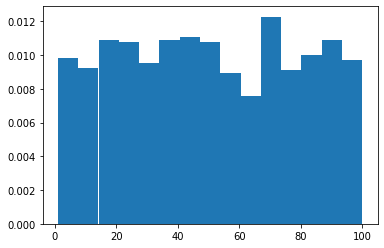

In [358]:
count, bins, ignored = plt.hist(s, 15, normed=True)

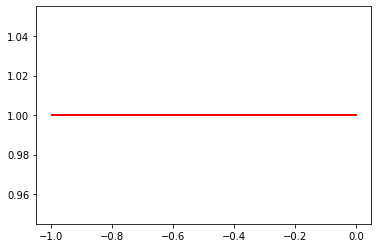

In [356]:
plt.plot(bins, np.ones_like(bins), linewidth=2, color='r')

In [363]:
s = np.random.uniform(0,1,10)

In [364]:
for i in 

array([0.60340592, 0.54228601, 0.04163108, 0.4894782 , 0.88065487,
       0.20663055, 0.55519701, 0.09582701, 0.10128205, 0.96954723])

Text(0, 0.5, '$p$')

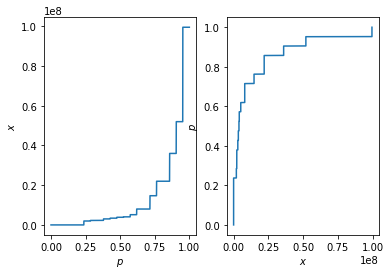

In [402]:
import matplotlib.pyplot as plt
import numpy as np

# create some randomly ddistributed data:
data = csa_206_unk_sampled

# sort the data:
data_sorted = np.sort(data)

# calculate the proportional values of samples
p = 1. * np.arange(len(data)) / (len(data) - 1)

# plot the sorted data:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.plot(p, data_sorted)
ax1.set_xlabel('$p$')
ax1.set_ylabel('$x$')

ax2 = fig.add_subplot(122)
ax2.plot(data_sorted, p)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$p$')

In [461]:
for i in csa_207: 
    print(i)

NameError: name 'csa_207' is not defined